## Training a RACE for handwriting digits generation

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from rcae.utils import utils
from rcae.block import Block

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

## Initialize tf.placeholders 

In [4]:
x_in = tf.placeholder(tf.float32, shape=[None,28,28,1],name='inputs')
x_out = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='outputs')
code_length = 128
code = tf.placeholder(tf.float32, shape=[None,code_length],name='code')

is_training = tf.placeholder(tf.bool, name='is_training')

## Encoder part

In [5]:
# Reisudal blocks
encode_flag = True
net = x_in
odd_flags = []
blocks_en = [
    [(16, 8, 2)],
    [(32, 16, 2)],
]
odd_flags = []
for i, block in enumerate(blocks_en):
    block_params = utils.get_block_en(block, is_training=is_training)
    # build the net
    block_obj = Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=encode_flag,
        scope = 'block'+str(i),
        summary_flag = True
        )
    net, odd_flag = block_obj.get_block()
    odd_flags.append(odd_flag)

(?, 14, 14, 16)
(?, 7, 7, 32)


In [6]:
# get shape of last block
encode_last_block_shape = net.get_shape()

In [7]:
# flatten layer
with tf.name_scope('flatten_en'):
    net = layers.flatten(net)
    tf.summary.histogram('flatten_en',net)
flatten_length = int(net.get_shape()[-1])

### Coder layer, i.e., the feature vector

In [8]:
with tf.name_scope('encoder_layer'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=code_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('encode_layer',net)
    code = net

## Decoder block

In [9]:
with tf.name_scope('flatten_de'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=flatten_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('flatten_de', net)

In [10]:
# flatten to convolve
with tf.name_scope('flatten_to_conv'):
    net = tf.reshape(
        net, 
        [-1, int(encode_last_block_shape[1]), 
         int(encode_last_block_shape[2]), int(encode_last_block_shape[3])])

In [11]:
# Residual blocks
block_list, block_stride = utils.get_block_list(blocks_en, input_depth=1)
blocks_de = utils.get_block_de_params(block_list, block_stride)

blocks_de_tmp = blocks_de.copy()
odd_flags_de = utils.get_odd_flags(odd_flags, blocks=blocks_de_tmp)

for i, block in enumerate(blocks_de):
    block_params = utils.get_block_de(block, is_training=is_training)
    # build the net
    block_obj = Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=False,
        scope = 'block'+str(i),
        summary_flag = True,
        odd_flags=odd_flags_de[i]
        )
    net = block_obj.get_block()
x_out = net

(?, 14, 14, 16)
(?, 28, 28, 1)


## Loss function, learning rate and training operations

In [12]:
# loss function
with tf.name_scope('loss'):
    cost = tf.reduce_mean(tf.square(x_out-x_in))
    tf.summary.scalar('loss', cost)

In [13]:
# learning rate: exponentially decaying
with tf.name_scope('learning_rate'):
    init_lr = tf.placeholder(tf.float32, name='LR')
    global_step = tf.placeholder(tf.float32, name="global_step")
    decay_step = tf.placeholder(tf.float32, name="decay_step")
    decay_rate = tf.placeholder(tf.float32, name="decay_rate")
    learning_rate = tf.train.exponential_decay(
        learning_rate = init_lr ,
        global_step = global_step,
        decay_steps = decay_step,
        decay_rate = decay_rate,
        staircase=False,
        name=None)   

In [14]:
# Train step 
# note: should add update_ops to the train graph
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

### Visualize the graph 

In [15]:
# Merge all the summaries and write to logdir
logdir = 'log_mnist'
if os.path.exists(logdir):
    os.system('rm -r %s' % logdir)
os.mkdir(logdir)
merged = tf.summary.merge_all()
# Initialize the variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_writer = tf.summary.FileWriter(logdir + '/train',
                                     sess.graph)
val_writer = tf.summary.FileWriter(logdir + '/validation',
                                   sess.graph)


## Load data and train the network

In [16]:
# Step1 load MNITST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", 
                                  one_hot=True,
                                  validation_size=2000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
def feed_dict(train,batchsize=100,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        xs, _ = mnist.train.next_batch(batchsize)
        f_dict = {x_in: xs.reshape([-1,28,28,1]), 
                  is_training: True}
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val,_ = mnist.validation.images,mnist.validation.labels
        f_dict = {x_in: x_val.reshape([-1,28,28,1]),
                  is_training: False}
    return f_dict

In [18]:
# Training the model by repeatedly running train_step
import time 
epochs = 100
batchsize= 100
num_batches = mnist.train.images.shape[0] // batchsize
# num_batches = 200

lr_init = 0.001
d_rate = 0.9

x_epoch = np.arange(0,epochs,1)
y_loss_trn = np.zeros(x_epoch.shape)
y_loss_val = np.zeros(x_epoch.shape)

# Init all variables
timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
print("[%s]: Epochs    Trn_loss    Val_loss" % (timestamp))
for i in range(epochs):
    lr_dict = {init_lr: lr_init, global_step:i,
               decay_step: i, decay_step: batchsize,
               decay_rate: d_rate}
    loss_trn_all = 0.0
    for b in range(num_batches):
        train_dict = feed_dict(True,lr_dict=lr_dict)
        # train
        summary_trn, _, loss_trn = sess.run(
            [merged, train_step, cost], 
            feed_dict=train_dict)
        loss_trn_all += loss_trn
    
    y_loss_trn[i] = loss_trn_all / num_batches
    train_writer.add_summary(summary_trn, i)
    # validation
    val_dict = feed_dict(False)
    summary_val, y_loss_val[i] = sess.run(
        [merged, cost],feed_dict=val_dict)
    val_writer.add_summary(summary_val, i)
    if i % 5 == 0:
        timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
        print('[%s]: %d    %.8f    %.8f' % (timestamp, i, 
                                            y_loss_trn[i], y_loss_val[i]))

[2018-02-07: 11:41:13]: Epochs    Trn_loss    Val_loss
[2018-02-07: 11:41:50]: 0    0.01586169    0.00494594
[2018-02-07: 11:44:47]: 5    0.00209629    0.00203937
[2018-02-07: 11:47:44]: 10    0.00158905    0.00169218
[2018-02-07: 11:50:42]: 15    0.00137787    0.00141061
[2018-02-07: 11:53:40]: 20    0.00124615    0.00133255
[2018-02-07: 11:56:38]: 25    0.00116339    0.00117872
[2018-02-07: 11:59:38]: 30    0.00110557    0.00116313
[2018-02-07: 12:02:40]: 35    0.00106438    0.00109908
[2018-02-07: 12:05:41]: 40    0.00102699    0.00107381
[2018-02-07: 12:08:41]: 45    0.00100184    0.00105740
[2018-02-07: 12:11:42]: 50    0.00097686    0.00108844
[2018-02-07: 12:14:40]: 55    0.00095731    0.00098758
[2018-02-07: 12:17:38]: 60    0.00093823    0.00099142
[2018-02-07: 12:20:37]: 65    0.00091568    0.00097779
[2018-02-07: 12:23:38]: 70    0.00090578    0.00096894
[2018-02-07: 12:26:40]: 75    0.00089272    0.00094615
[2018-02-07: 12:29:41]: 80    0.00087893    0.00099036
[2018-02-07:

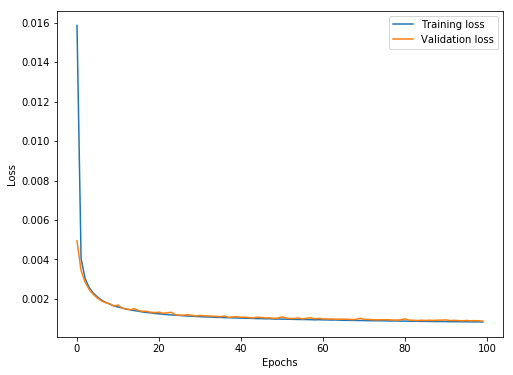

In [19]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_loss_trn)
plt.plot(x_epoch, y_loss_val)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Test the network

In [20]:
# test a image
n_examples = 10
img, _ = mnist.validation.next_batch(n_examples)
img = img.reshape(-1,28,28,1)

In [21]:
img_est = sess.run(x_out, feed_dict={x_in: img, is_training: False})

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


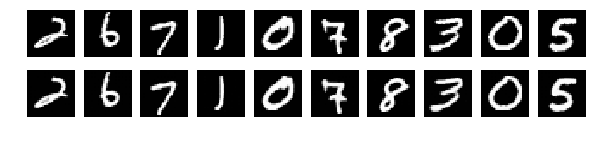

In [22]:
fig, axs = plt.subplots(2, n_examples, figsize=(n_examples, 2))
for example_i in range(n_examples):
    # original
    axs[0][example_i].imshow(np.reshape(img[example_i, :], (28, 28)), cmap='gray')
    axs[0][example_i].axis('off')
    # reconstructed
    axs[1][example_i].imshow(np.reshape(img_est[example_i, :], (28, 28)), cmap='gray')
    axs[1][example_i].axis('off')

fig.show()
plt.draw()

## Save the trained network

In [26]:
foldname = "./rcae_mnist"
name = "rcae.pkl"
netname = "model_rcae.ckpt"
namepath = os.path.join(foldname, name)
netpath = os.path.join(foldname, netname)
savedict = {'x_in': x_in.name,
            'x_out': x_out.name,
            'code': code.name,
            'is_training': is_training.name,
            'init_lr': init_lr.name,
            'global_step': global_step.name,
            'decay_step': decay_step.name,
            'decay_rate': decay_rate.name,
            'netpath': netpath}
if os.path.exists(foldname):
    os.system("rm -r %s" % (foldname))
os.mkdir(foldname)
utils.save_net(sess=sess,
               namepath=namepath,
               netpath=netpath,
               savedict=savedict)